## CSML1010 Group3 Course_Project - Milestone 2 - Baseline Machine Learning Implementation
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

---

## Workbook Setup and Data Preparation

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pickle

In [4]:
filename = 'X_train_bow'
infile = open(filename,'rb')
X_train_bow = pickle.load(infile)
infile.close()

In [5]:
filename = 'X_test_bow'
infile = open(filename,'rb')
X_test_bow = pickle.load(infile)
infile.close()

In [6]:
filename = 'rm_chi_opt_bow.x_train_sel'
infile = open(filename,'rb')
X_train_bow_chi_opt = pickle.load(infile)
infile.close()

In [7]:
filename = 'rm_chi_opt_bow.x_test_sel'
infile = open(filename,'rb')
X_test_bow_chi_opt = pickle.load(infile)
infile.close()

In [8]:
filename = 'y_train'
infile = open(filename,'rb')
y_train = pickle.load(infile)
infile.close()

In [9]:
filename = 'y_test'
infile = open(filename,'rb')
y_test = pickle.load(infile)
infile.close()

---

## 1. Benchmark Comparison

### Benchmark the following four models: Logistic Regression (Multinomial) Naive Bayes Linear Support Vector Machine Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

#### Baseline Features

In [11]:
# Baseline Features
model_ids = ['RF', 'SVC', 'NB','LR']
models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model, model_id in zip(models, model_ids):
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_bow, y_train, scoring='f1_weighted', cv=CV)

    for i in range(0, 10, 1):
        entries.append((model_id, model_name, 'baseline', 'default', '', f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])       
cv_df_BaseFTR = cv_df

#### Optimised Features

In [12]:
# Optimised Features
model_ids = ['RF', 'SVC', 'NB','LR']
models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1)
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
#entries = []

for model, model_id in zip(models, model_ids):
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_bow_chi_opt, y_train, scoring='f1_weighted', cv=CV)

    for i in range(0, 10, 1):
        entries.append((model_id, model_name, 'optimized', 'default', '', f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
cv_df_OptFTR = cv_df

### Modeling

Four different models were verified as part of our modeling: 
+ Random Forest
+ Linear SVC
+ Multinomial Naïve Bayes
+ Logistic Regression 

The modeling was first done on our baseline features and using the selected optimised features identified as part of milestone 1: Naïve Bayes using Chi Squared.

In [13]:
models_df = cv_df.groupby(['Model_Id', 'Model','Features', 'Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params               
LR       LogisticRegression     baseline  default                      0.7413298
                                optimized default                      0.7251940
NB       MultinomialNB          baseline  default                      0.6216321
                                optimized default                      0.7375412
RF       RandomForestClassifier baseline  default                      0.5814939
                                optimized default                      0.6902044
SVC      LinearSVC              baseline  default                      0.7177150
                                optimized default                      0.7080949

In [14]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [15]:
models_df.style.apply(highlight_max)

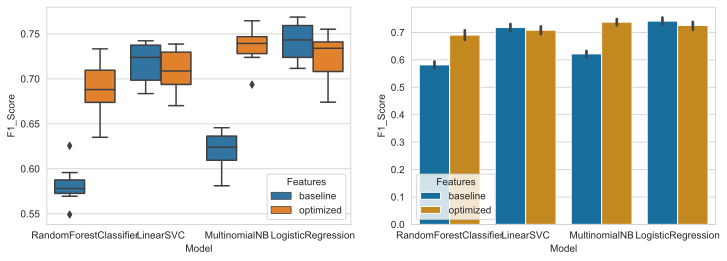

In [16]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)
sns.boxplot(x='Model', y='F1_Score', data=cv_df, hue='Features', ax=ax1);
#sns.stripplot(x='Model', y='F1_Score', data=cv_df, hue='Features', size=6, jitter=True, edgecolor="gray", linewidth=2, ax=ax1);
sns.barplot(y='F1_Score', x='Model', data=cv_df, palette="colorblind", hue='Features', ax=ax2);


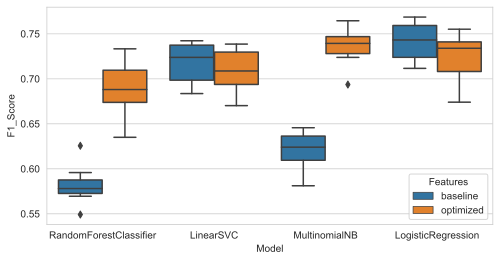

In [17]:
import seaborn as sns

fig, (ax1) = plt.subplots(figsize=(8, 4), ncols=1, sharex=True)
sns.boxplot(x='Model', y='F1_Score', data=cv_df, hue='Features', ax=ax1);

## Optimize the Hyperparameters Using Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV

class Estimator_Parameters:
    def __init__(self, estimator, parameters, feat_type, x, y):
        self.estimator = estimator
        self.parameters = parameters
        self.feat_type = feat_type
        self.x = x
        self.y = y

def Get_Best_Parameters(est_param):
    grid_search = GridSearchCV(estimator = est_param.estimator,
                            param_grid = est_param.parameters,
                            scoring = 'f1_weighted',
                            cv= 10,
                            n_jobs = -1)
    grid_search = grid_search.fit(est_param.x, est_param.y)
    return grid_search.best_score_, grid_search.best_params_

In [19]:
from sklearn.model_selection import GridSearchCV

est_param_arr = [
    Estimator_Parameters(RandomForestClassifier(), [{'n_estimators': [90,100,110],'max_depth': [6,8,10], 'random_state': [0,1,2]}], "optimized", X_train_bow_chi_opt, y_train),
    Estimator_Parameters(LinearSVC(), [{'C': [500,1000,1200, 1300],'loss': ['hinge', 'squared_hinge'], 'dual': [True, False], 'penalty': ['l1', 'l2'], 'max_iter': [700,800,900,1000]}], "optimized", X_train_bow_chi_opt, y_train),
    Estimator_Parameters(MultinomialNB(), [{'alpha': [0.3,0.4,0.42,0.44,1],'fit_prior': [True, False]}], "optimized", X_train_bow_chi_opt, y_train),
    Estimator_Parameters(LogisticRegression(), [{'C': [0.1,0.3,0.5,1,2,3], 'penalty': ['l1', 'l2', 'elasticnet', 'none'],'dual': [True, False], 'multi_class': ['auto', 'ovr', 'multinomial']}], "optimized", X_train_bow_chi_opt, y_train)
]

grid_dict = {}

for est_param, model_id in zip(est_param_arr, model_ids):
    estimator_name = est_param.estimator.__class__.__name__
    best_accuracy, best_parameters = Get_Best_Parameters(est_param)
    entries.append([model_id, estimator_name, est_param.feat_type, 'tuned', str(best_parameters), best_accuracy])
    print(estimator_name, best_accuracy, best_parameters, est_param.feat_type)
    grid_dict[estimator_name] = best_parameters

RandomForestClassifier 0.5827057793018381 {'max_depth': 10, 'n_estimators': 90, 'random_state': 0} optimized
LinearSVC 0.6506663660634833 {'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 900, 'penalty': 'l2'} optimized
MultinomialNB 0.7466943954822883 {'alpha': 0.42, 'fit_prior': True} optimized
LogisticRegression 0.7335620758966519 {'C': 0.5, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'} optimized


### Parameter Tuning
The model's hyperparameters were optimized using the GridSearchCV function from sci-kitlearn.  The hyperparameters verified were:
+ __Random Forest:__ max_depth; n_estimators; random_state
+ __Linear SVC:__ C; dual; loss; max_iter; penalty
+ __MultinomialNB:__ alpha; fit_prior
+ __Logistic Regression:__ C; dual; multi_class; auto; penalty


In [20]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id', 'Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params                                                                                         
LR       LogisticRegression     baseline  default                                                                                                0.7413298
                                optimized default                                                                                                0.7251940
                                          tuned       {'C': 0.5, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}                           0.7335621
NB       MultinomialNB          baseline  default                                                                                                0.6216321
                                optimized default                                                                                                0.7375412
                                          tuned       {'alpha': 0.42, 'fit_prior': True}                                                         0.7466944
RF       RandomForestClassifier baseline  default                                                                                                0.5814939
                                optimized default                                                                                                0.6902044
                                          tuned       {'max_depth': 10, 'n_estimators': 90, 'random_state': 0}                                   0.5827058
SVC      LinearSVC              baseline  default                                                                                                0.7177150
                                optimized default                                                                                                0.7080949
                                          tuned       {'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 900, 'penalty': 'l2'}      0.6506664

## 2. a. Learning Curves: Training/ Testing Errors - Optimized Hyperarameters

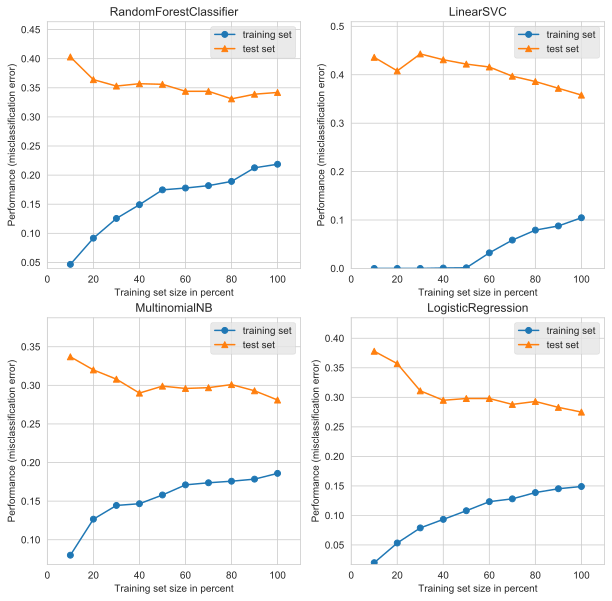

In [21]:
from mlxtend.plotting import plot_learning_curves
import itertools
import matplotlib.gridspec as gridspec

models = [
    RandomForestClassifier(**grid_dict['RandomForestClassifier']),
    LinearSVC(**grid_dict['LinearSVC']),
    MultinomialNB(**grid_dict['MultinomialNB']),
    LogisticRegression(**grid_dict['LogisticRegression']),
]

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(X_train_bow_chi_opt, y_train, X_test_bow_chi_opt, y_test, model, print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

---

## 2. b. Learning Curves: Training/Testing Accuracy - Optimized Hyperarameters

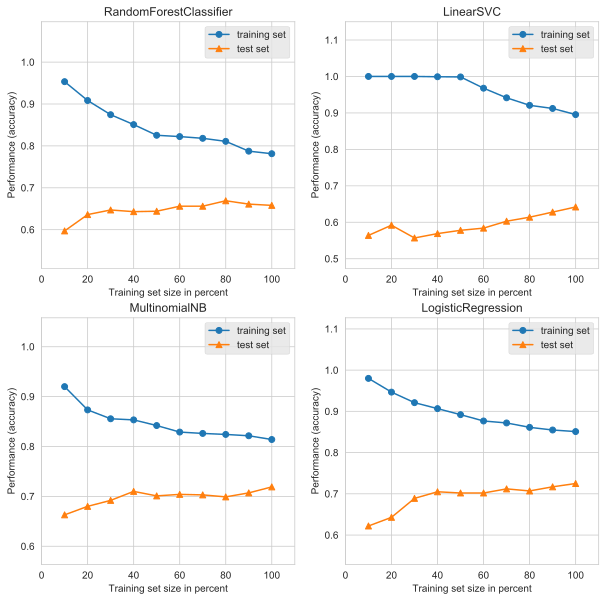

In [22]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.gridspec as gridspec
import itertools

models = [
    RandomForestClassifier(**grid_dict['RandomForestClassifier']),
    LinearSVC(**grid_dict['LinearSVC']),
    MultinomialNB(**grid_dict['MultinomialNB']),
    LogisticRegression(**grid_dict['LogisticRegression']),
]

fig3 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig3 = plot_learning_curves(X_train_bow_chi_opt, y_train, X_test_bow_chi_opt, y_test, model, scoring='accuracy', print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

### Learning Curves
The learning curves for training/testing indicated the following: low error and a high gap between the training and the validation curves.  This indicates:
+ High variance
+ Low bias

Increasing the number of samples gave us more convergence on our curves, but two of the models continue to indicate 100% validation indicating more samples are required.

---

## 3. Ensemble Learning

#### Initialize Models with optimized hyperparameters

In [23]:
clf1 = RandomForestClassifier(**grid_dict['RandomForestClassifier'])
clf2 = LinearSVC(**grid_dict['LinearSVC'])
clf3 = MultinomialNB(**grid_dict['MultinomialNB'])
clf4 = LogisticRegression(**grid_dict['LogisticRegression'])

## Bagging

In [24]:
from sklearn.ensemble import BaggingClassifier

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=10, max_samples=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=10, max_samples=0.8)

## Learning Curves for Bagged Models

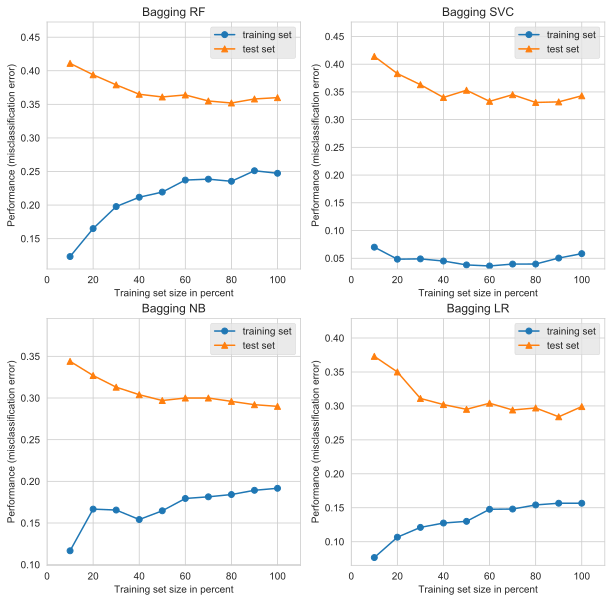

In [25]:
from mlxtend.plotting import plot_learning_curves

models = [
    bagging1, bagging2, bagging3, bagging4
]
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, label, grd in zip(models, labels, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(X_train_bow_chi_opt, y_train, X_test_bow_chi_opt, y_test, model, print_model=False, style='ggplot')
    plt.title(label)
         
plt.show()

## Bagging Scores Varied by Ensemble Size

---

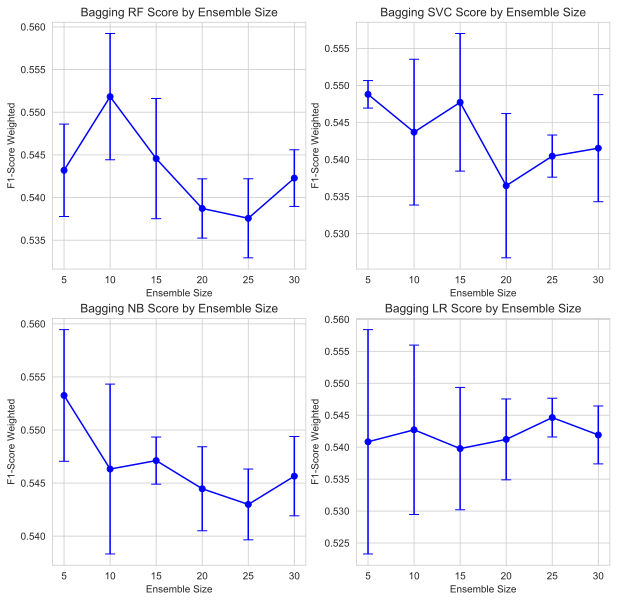

In [26]:
clf_list = [clf1, clf2, clf3, clf4]
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, labels, grid):  
    num_est = map(int, np.linspace(5,30,6))
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    for n_est in num_est:    
        bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
        scores = cross_val_score(bg_clf, X_train_bow_chi_opt, y_train, cv=3, scoring='f1_weighted')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())

    num_est = list(map(int, np.linspace(5,30,6)))
    ax = plt.subplot(gs[grd[0], grd[1]]) 

    (_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)
                                                                                         
    fig2 = plt.ylabel('F1-Score Weighted'); plt.xlabel('Ensemble Size'); plt.title(label + ' Score by Ensemble Size');
plt.show()

In [27]:
bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=30, max_samples=0.9)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.7)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=20, max_samples=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=15, max_samples=0.7)

In [28]:
from mlxtend.plotting import plot_decision_regions
import itertools
import matplotlib.gridspec as gridspec

labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']
clf_list = [bagging1, bagging2, bagging3, bagging4]

for clf, label, model_id in zip(clf_list, labels, model_ids):          
    scores = cross_val_score(clf, X_train_bow_chi_opt, y_train, cv=3, scoring='f1_weighted')
    entries.append([model_id, label, 'optimized', 'tuned', '', scores.mean()])
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.55 (+/- 0.00) [Bagging RF]
Accuracy: 0.68 (+/- 0.01) [Bagging SVC]
Accuracy: 0.74 (+/- 0.01) [Bagging NB]
Accuracy: 0.72 (+/- 0.00) [Bagging LR]


In [29]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id','Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params                                                                                         
LR       Bagging LR             optimized tuned                                                                                                  0.7163883
         LogisticRegression     baseline  default                                                                                                0.7413298
                                optimized default                                                                                                0.7251940
                                          tuned       {'C': 0.5, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}                           0.7335621
NB       Bagging NB             optimized tuned                                                                                                  0.7365168
         MultinomialNB          baseline  default                                                                                                0.6216321
                                optimized default                                                                                                0.7375412
                                          tuned       {'alpha': 0.42, 'fit_prior': True}                                                         0.7466944
RF       Bagging RF             optimized tuned                                                                                                  0.5474932
         RandomForestClassifier baseline  default                                                                                                0.5814939
                                optimized default                                                                                                0.6902044
                                          tuned       {'max_depth': 10, 'n_estimators': 90, 'random_state': 0}                                   0.5827058
SVC      Bagging SVC            optimized tuned                                                                                                  0.6780316
         LinearSVC              baseline  default                                                                                                0.7177150
                                optimized default                                                                                                0.7080949
                                          tuned       {'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 900, 'penalty': 'l2'}      0.6506664

The Bagging ensemble did not provide any improvements on the baseline and optimized modeling.

## Boosting

In [30]:
from sklearn.ensemble import AdaBoostClassifier

boosting1 = AdaBoostClassifier(base_estimator=clf1)
boosting2 = AdaBoostClassifier(base_estimator=clf2, algorithm='SAMME')
boosting3 = AdaBoostClassifier(base_estimator=clf3)
boosting4 = AdaBoostClassifier(base_estimator=clf4)

## Boosting Scores Varied by Ensemble Size

F1-Score Weighted: 0.59 (+/- 0.01) [AdaBoost RF, n_estimators: 1]
F1-Score Weighted: 0.65 (+/- 0.01) [AdaBoost RF, n_estimators: 5]
F1-Score Weighted: 0.66 (+/- 0.00) [AdaBoost RF, n_estimators: 10]
F1-Score Weighted: 0.66 (+/- 0.01) [AdaBoost RF, n_estimators: 15]
F1-Score Weighted: 0.65 (+/- 0.00) [AdaBoost RF, n_estimators: 20]

F1-Score Weighted: 0.69 (+/- 0.01) [AdaBoost SVC, n_estimators: 1]
F1-Score Weighted: 0.69 (+/- 0.01) [AdaBoost SVC, n_estimators: 5]
F1-Score Weighted: 0.61 (+/- 0.01) [AdaBoost SVC, n_estimators: 10]
F1-Score Weighted: 0.67 (+/- 0.01) [AdaBoost SVC, n_estimators: 15]
F1-Score Weighted: 0.63 (+/- 0.02) [AdaBoost SVC, n_estimators: 20]

F1-Score Weighted: 0.47 (+/- 0.00) [AdaBoost NB, n_estimators: 1]
F1-Score Weighted: 0.52 (+/- 0.01) [AdaBoost NB, n_estimators: 5]
F1-Score Weighted: 0.58 (+/- 0.01) [AdaBoost NB, n_estimators: 10]
F1-Score Weighted: 0.59 (+/- 0.02) [AdaBoost NB, n_estimators: 15]
F1-Score Weighted: 0.58 (+/- 0.00) [AdaBoost NB, n_estimators

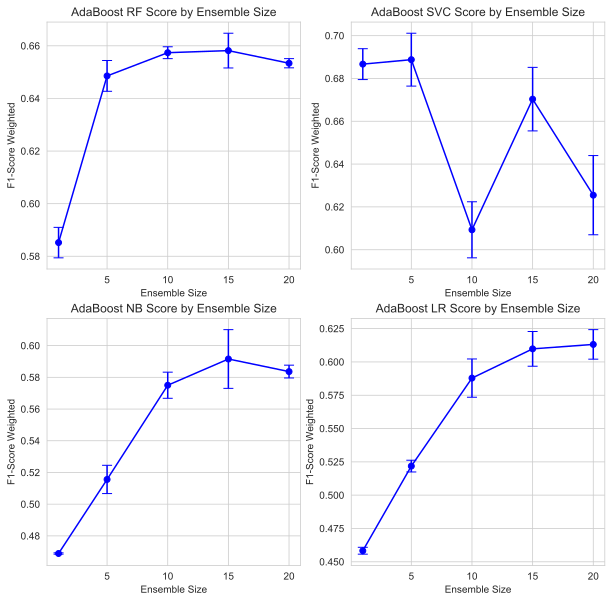

In [31]:
from sklearn.ensemble import AdaBoostClassifier

bst_list = [boosting1, boosting2, boosting3, boosting4]
labels = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

num_est = map(int, np.linspace(5,30,6))

for boosting, label, grd in zip(bst_list, labels, grid):  
    num_est = map(int, np.linspace(1,20,5))
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    for n_est in num_est:
        boosting.set_params(n_estimators=n_est)
        scores = cross_val_score(boosting, X_train_bow_chi_opt, y_train, cv=3, scoring='f1_weighted')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())
        print("F1-Score Weighted: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label + ', n_estimators: ' + str(n_est)))
    
    ax = plt.subplot(gs[grd[0], grd[1]]) 
    num_est = list(map(int, np.linspace(1,20,5)))
    (_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)                                                                                                                                
    fig2 = plt.ylabel('F1-Score Weighted'); plt.xlabel('Ensemble Size'); plt.title(label + ' Score by Ensemble Size');
    print('')


## Learning Curves for Boosted Models

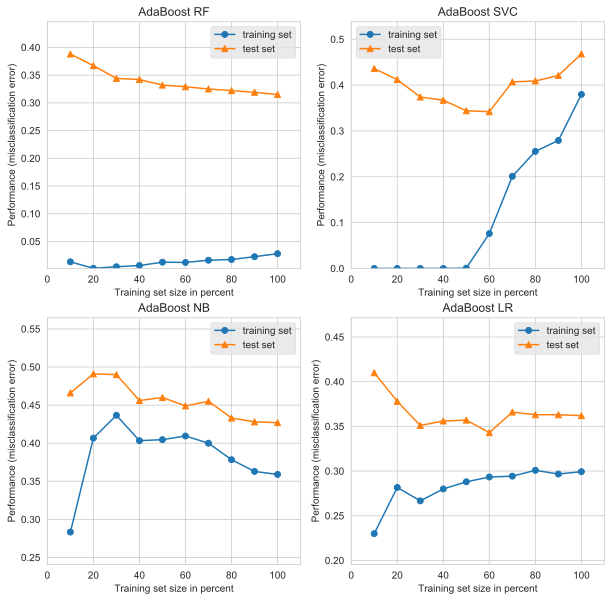

In [32]:
#plot Boosting learning curve
fig_bst = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for boosting, label, grd in zip(bst_list, labels, grid):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig_bst = plot_learning_curves(X_train_bow_chi_opt, y_train, X_test_bow_chi_opt, y_test, boosting, print_model=False, style='ggplot')
    plt.title(label)
plt.show()

In [33]:
boosting1 = AdaBoostClassifier(base_estimator=clf1, n_estimators=5)
boosting2 = AdaBoostClassifier(base_estimator=clf2, n_estimators=15, algorithm='SAMME')
boosting3 = AdaBoostClassifier(base_estimator=clf3, n_estimators=20)
boosting4 = AdaBoostClassifier(base_estimator=clf4, n_estimators=5)
boost_list = [boosting1, boosting2, boosting3, boosting4]
labels_bst = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']

In [34]:
from sklearn.ensemble import AdaBoostClassifier

labels = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']
bst_list = [boosting1, boosting2, boosting3, boosting4]

for boosting, label, model_id in zip(bst_list, labels, model_ids):
    
    scores = cross_val_score(boosting, X_train_bow_chi_opt, y_train, cv=3, scoring='f1_weighted')
    entries.append([model_id, label, 'optimized', 'tuned', '', scores.mean()])
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

Accuracy: 0.65 (+/- 0.00) [AdaBoost RF]
Accuracy: 0.67 (+/- 0.01) [AdaBoost SVC]
Accuracy: 0.58 (+/- 0.00) [AdaBoost NB]
Accuracy: 0.52 (+/- 0.00) [AdaBoost LR]


In [35]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id','Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params                                                                                         
LR       AdaBoost LR            optimized tuned                                                                                                  0.5218138
         Bagging LR             optimized tuned                                                                                                  0.7163883
         LogisticRegression     baseline  default                                                                                                0.7413298
                                optimized default                                                                                                0.7251940
                                          tuned       {'C': 0.5, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}                           0.7335621
NB       AdaBoost NB            optimized tuned                                                                                                  0.5836239
         Bagging NB             optimized tuned                                                                                                  0.7365168
         MultinomialNB          baseline  default                                                                                                0.6216321
                                optimized default                                                                                                0.7375412
                                          tuned       {'alpha': 0.42, 'fit_prior': True}                                                         0.7466944
RF       AdaBoost RF            optimized tuned                                                                                                  0.6467902
         Bagging RF             optimized tuned                                                                                                  0.5474932
         RandomForestClassifier baseline  default                                                                                                0.5814939
                                optimized default                                                                                                0.6902044
                                          tuned       {'max_depth': 10, 'n_estimators': 90, 'random_state': 0}                                   0.5827058
SVC      AdaBoost SVC           optimized tuned                                                                                                  0.6703381
         Bagging SVC            optimized tuned                                                                                                  0.6780316
         LinearSVC              baseline  default                                                                                                0.7177150
                                optimized default                                                                                                0.7080949
                                          tuned       {'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 900, 'penalty': 'l2'}      0.6506664

The Boosting ensemble did not provide any improvements on the baseline and optimized modeling.

## Stacking

In [36]:
from mlxtend.classifier import StackingClassifier

sclf = StackingClassifier(classifiers=[clf1, clf2, clf4], meta_classifier=clf3)

labels = ['Random Forest', 'LinearSVC', 'Stacking LR', 'MultinomialNB']
clf_list = [clf1, clf2, clf4, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, labels, grid):
        
    scores = cross_val_score(clf, X_train_bow_chi_opt, y_train, cv=3, scoring='f1_weighted')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    if (label == 'Stacking LR'):
        entries.append(['Stack', label, 'optimized', 'tuned', '', scores.mean()])
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.58 (+/- 0.00) [Random Forest]
Accuracy: 0.62 (+/- 0.01) [LinearSVC]
Accuracy: 0.72 (+/- 0.00) [Stacking LR]
Accuracy: 0.12 (+/- 0.01) [MultinomialNB]


<Figure size 1000x800 with 0 Axes>

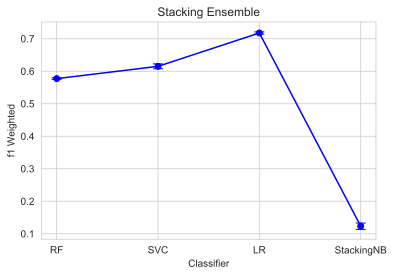

In [37]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['RF', 'SVC', 'LR', 'StackingNB'])        
plt.ylabel('f1 Weighted'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

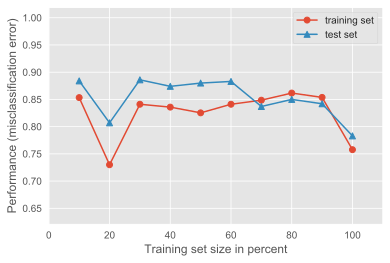

In [38]:
#plot Stacking learning curve
plt.figure()
plot_learning_curves(X_train_bow_chi_opt, y_train, X_test_bow_chi_opt, y_test, sclf, print_model=False, style='ggplot')
plt.show()

In [39]:
from mlxtend.classifier import StackingClassifier

sclf_bst = StackingClassifier(classifiers=[boosting1, boosting2, boosting4], meta_classifier=boosting3)

labels = ['Boosted RF', 'Boosted SVC', 'Boosted LR', 'Stacking Boosted NB']
#clf_list = [clf1, clf2, clf3, sclf]
bst_list = [boosting1, boosting2, boosting4, sclf_bst]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(bst_list, labels, grid):
        
    scores = cross_val_score(clf, X_train_bow_chi_opt, y_train, cv=3, scoring='f1_weighted')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    if (label == 'Stacking Boosted NB'):
        entries.append(['Stack', label, 'optimized', 'tuned', '', scores.mean()])
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.65 (+/- 0.01) [Boosted RF]
Accuracy: 0.67 (+/- 0.01) [Boosted SVC]
Accuracy: 0.52 (+/- 0.00) [Boosted LR]
Accuracy: 0.07 (+/- 0.02) [Stacking Boosted NB]


<Figure size 1000x800 with 0 Axes>

In [40]:
result_df = pd.DataFrame(entries, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])
models_df = result_df.groupby(['Model_Id', 'Model','Features','Hyper_Param', 'Best_Params']).agg(['mean'])
models_df.columns = models_df.columns.map('_'.join)
models_df

F1_Score_mean
Model_Id Model                  Features  Hyper_Param Best_Params                                                                                         
LR       AdaBoost LR            optimized tuned                                                                                                  0.5218138
         Bagging LR             optimized tuned                                                                                                  0.7163883
         LogisticRegression     baseline  default                                                                                                0.7413298
                                optimized default                                                                                                0.7251940
                                          tuned       {'C': 0.5, 'dual': False, 'multi_class': 'ovr', 'penalty': 'l2'}                           0.7335621
NB       AdaBoost NB            optimized tuned                                                                                                  0.5836239
         Bagging NB             optimized tuned                                                                                                  0.7365168
         MultinomialNB          baseline  default                                                                                                0.6216321
                                optimized default                                                                                                0.7375412
                                          tuned       {'alpha': 0.42, 'fit_prior': True}                                                         0.7466944
RF       AdaBoost RF            optimized tuned                                                                                                  0.6467902
         Bagging RF             optimized tuned                                                                                                  0.5474932
         RandomForestClassifier baseline  default                                                                                                0.5814939
                                optimized default                                                                                                0.6902044
                                          tuned       {'max_depth': 10, 'n_estimators': 90, 'random_state': 0}                                   0.5827058
SVC      AdaBoost SVC           optimized tuned                                                                                                  0.6703381
         Bagging SVC            optimized tuned                                                                                                  0.6780316
         LinearSVC              baseline  default                                                                                                0.7177150
                                optimized default                                                                                                0.7080949
                                          tuned       {'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 900, 'penalty': 'l2'}      0.6506664
Stack    Stacking Boosted NB    optimized tuned                                                                                                  0.0666569
         Stacking LR            optimized tuned                                                                                                  0.7177023

The Stacking performed poorly on our modeling.

---

## Summary of Findings

#### Benchmarking of F1 Scores of Models for Baseline, Bagging, Boosting and Stacking

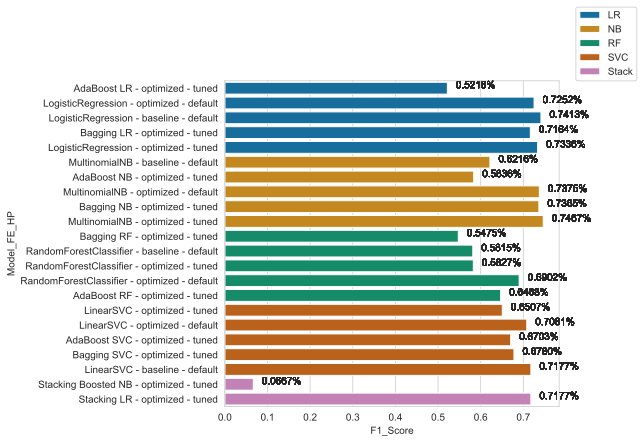

In [41]:
result_df['Model_FE_HP'] = result_df['Model'] + ' - ' + result_df['Features'] + ' - ' + result_df['Hyper_Param']
fig, (ax1) = plt.subplots(figsize=(6, 6), ncols=1)
g = sns.barplot(x='F1_Score', y='Model_FE_HP', data=result_df.sort_values(by=['Model_Id','F1_Score']), palette="colorblind", hue='Model_Id', dodge=False, ci=None, ax=ax1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)

total = len(result_df['Model_FE_HP'])
def annotateBars(row, ax=ax): 
    for p in ax.patches:
        val = '{:.4f}%'.format(p.get_width())
        #percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(val, (x, y))

plot = result_df.apply(annotateBars, ax=ax1, axis=1)
plt.show()


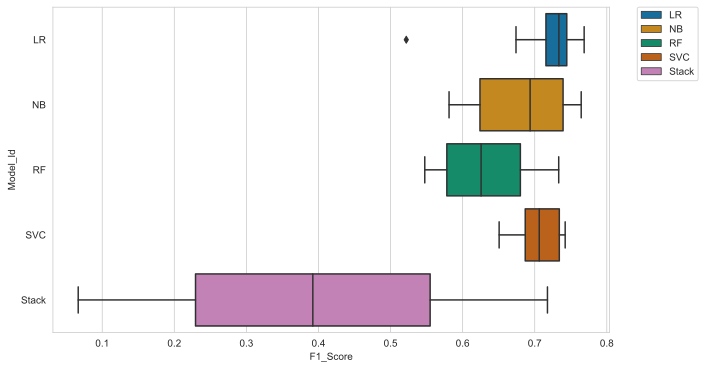

In [42]:
fig = plt.subplots(figsize=(10, 6))
sns.boxplot(x='F1_Score', y='Model_Id', data=result_df.sort_values(by='Model_Id'), palette="colorblind", hue='Model_Id', dodge=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

#### Model Evaluation Results with F1 Score

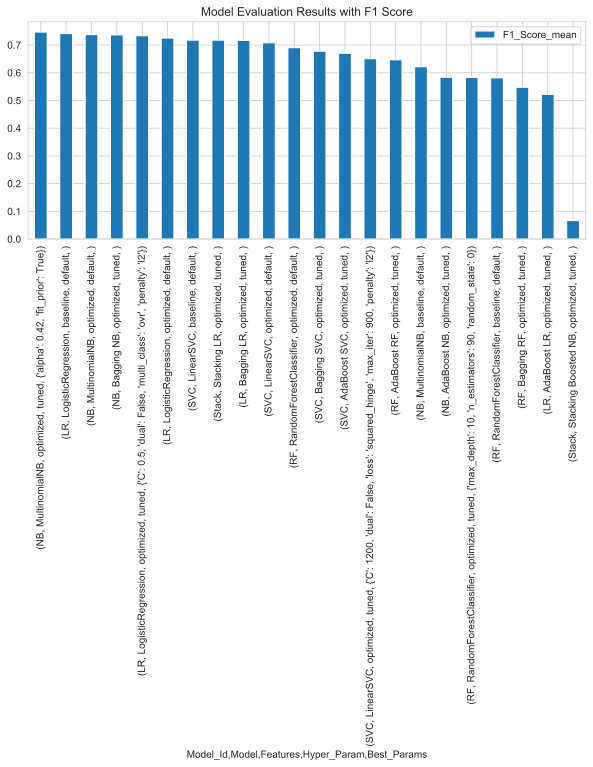

In [43]:
models_df.sort_values(by='F1_Score_mean', ascending=False).\
plot(y="F1_Score_mean", kind='bar', title="Model Evaluation Results with F1 Score", figsize=(10, 4));

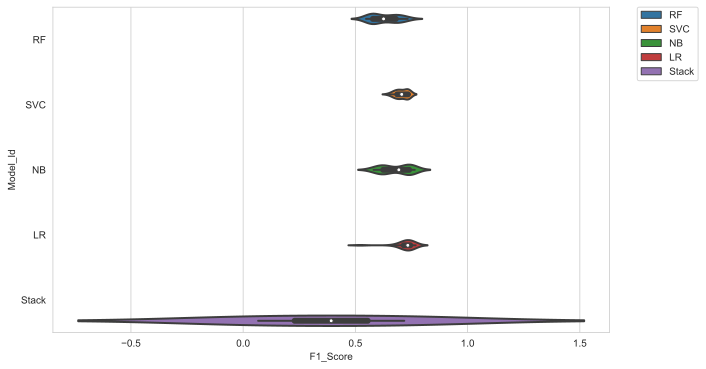

In [44]:
fig = plt.subplots(figsize=(10, 6))
sns.violinplot(x='F1_Score', y='Model_Id', data=result_df, hue='Model_Id', size=6, jitter=True, edgecolor="gray", linewidth=2);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);